__Preambule__

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# %%capture
# from tqdm.notebook import tqdm
# tqdm().pandas()

In [4]:
from ExpLorer_2 import *

In [6]:
status.iloc[0]

path to exp            /data/Sandra/2020/2020_08_05/Experiment63b.lif
experiment                                          Experiment63b.lif
series                                                      Series003
SizeT                                                           10939
SizeX                                                             256
SizeY                                                             256
SizeZ                                                               1
pxSize                                                           1.11
pxUnit                                                             µm
Frequency                                                        19.8
Duration                                       0 days 00:09:13.243574
gap                                                               NaN
Time Range                                                        all
Duration [s]                                                  552.475
path to movie       

In [ ]:
## importing stuff

import json
from collections import OrderedDict
from copy import deepcopy

import os
import pickle
from time import sleep
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import javabridge
from bioformats import JARS as bfJARS
javabridge.start_vm(class_path=bfJARS, max_heap_size="20G")
# import numpy as np
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
from IPython.display import display
import pandas as pd
from islets.Recording import Recording, parse_leica
from islets.utils import get_filterSizes
from general_functions import td_nanfloor, td2str
from copy import deepcopy

from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html

def cellTransform(cellvalue, id=None, verbose=False):
    import numpy as np
    
    if issubclass(type(cellvalue),(bool,np.bool_)):
        if verbose:
            print ("creating a checklist")
        out = dcc.Checklist(id=id,
                             options=[{"label":"✔" if cellvalue else "✘","value":None}],
                             value=[None]*(1-int(cellvalue)),
                             labelStyle={
                                 "color":"green" if cellvalue else "red",
#                                  "padding":"3px"
                             }
                            )
#     elif issubclass(type(cellvalue),(dict,)):
#         out = dcc.Checklist(id=id,
#                              options=[{"label":(str(k).replace(" ","")+("✔" if cellvalue[k] else "✘")), "value":k} for k in cellvalue],
#                              value = [k for k in cellvalue if not cellvalue[k]],
# #                              style={"height":"10px",},
#                              labelStyle={
#                                  "width":"100px",
#                                  "display":"block"
#                                         }
#                             )
    elif issubclass(type(cellvalue),(str,int,float,np.int_)):
        out = cellvalue
    else:
        out = str(cellvalue)
    return html.Div(out,style={
                                 "font-family":"monospace",
                                 "font-size":"14px",
                             },)
#     if issubclass(type(value),str):

def mystyle(col):
    return {"border":'thin lightgrey solid',
            "text-align": "left" if "pickle" in col else None,
            "width": {
                "Series Durations":"120px",
                "Duration":"100px",
                "pickles":"150px",
                "exp":"150px",
                "series":"150px",
                     }.get(col),
           }

def generate_table(dataframe, max_rows=100):
    rows = []
    for i in range(min(len(dataframe), max_rows)):
        row = []
        for col in dataframe.columns:
            value = dataframe.iloc[i][col]
#             row.append(html.Td(value if issubclass(type(value),str) else dcc.Checklist(options=[{"label":"item"}]),
# #                                style=style
#                               ))
            row.append(html.Td(cellTransform(value, id=f"table-{col}-{i}"),
                               style=mystyle(col),
                              ))
        rows.append(html.Tr(row,
                            style={"border":'thin lightgrey solid'},
#                             border='thin lightgrey solid' 
                           ))

    return html.Table(
        # Header
        [html.Tr([html.Th(col, style=mystyle(col)) for col in dataframe.columns],
                            style={"border":'thick lightgrey solid'},)] +
        # Body
        rows,
        style={
            "width": "1300px",
            "text-align":"right",
            "table-layout": "fixed"
        }
    ) 

In [219]:
def import_data(recordings, forceMetadataParse=False):
    global md
    status = []
    ilifs = 0
    for pathToRecording in tqdm(recordings):
        print ("#"*20, pathToRecording)
        try:
            rec = Recording(pathToRecording)
        except:
            print ("Could not import ", pathToRecording)
            continue
        recType = "Nikon" if pathToRecording.endswith(".nd2") else "Leica"
        if forceMetadataParse:
            rec.parse_metadata()
            rec.save_metadata()
        if recType=="Leica":
            sers = parse_leica(rec)
        else:
            print ("Nikon not yet supported. Sorry. Bug me to enable it.")
            continue
            

        analysisFolder = os.path.join(rec.folder, rec.Experiment+"_analysis")
        if not os.path.isdir(analysisFolder):
            os.makedirs(analysisFolder)

        for series in sers:
#             if recType=="Leica":
            subdirs = get_series_dir(pathToRecording, series)
#             else:
#                 subdirs = os.listdir(analysisFolder)
            for ser in subdirs:
                md = pd.Series()
                md["path to exp"] = pathToRecording
                md["experiment"] = os.path.split(pathToRecording)[-1]
                md["series"] = series
                try:
                    rec.import_series(series, onlyMeta=True)
                except:
                    print (f"could not import {series}")
                    status += [md]
                    continue
                
                saveDir = os.path.join(analysisFolder, ser)
                if "_" in ser:
                    md["Frame Range"] = [float(t) for t in ser.split("_")[-1].split("-")]
                else:
                    md["Frame Range"] = "all"
                for k,v in rec.Series[ser]["metadata"].items(): md[k] = v
                fs = get_filterSizes(md.pxSize)
                movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")
                md["movie done"] = os.path.isfile(movieFilename)
                if md["movie done"]:
                    md["movie size [MB]"] = np.round(os.path.getsize(movieFilename)/10**6,1)
                for k in ["bit depth", "Start time", "End time","Name","frame_range"]: # , "individual Series"
                    try:    del md[k]
                    except: pass
                times = ["00:00"]+[td2str(el) for el in md["individual Series"]["Duration"].cumsum()]
                md["Series Durations"] = " \n".join(["%s [%s-%s]"%(name.lstrip("Series0"), t0, t1) for name, t0, t1 in zip(md["individual Series"]["Name"], times[:-1], times[1:])])
#                 md["Series Durations"] = ["%s [%s]"%(r["Name"].replace("Series","S"), td2str(td_nanfloor(r["Duration"]))) for _,r in md["individual Series"].iterrows()]
#                 md["Series Durations"] = "\n".join(md["Series Durations"])
                del md["individual Series"]
                pklsDone = {}
                for fsize in fs:
                    pickleFile = os.path.join(saveDir, ".".join(map(str,fsize))+"_rois.pkl")
                    pickleThere = os.path.isfile(pickleFile)
                    pklsDone[fsize] = pickleThere
                md["pickles done"] = pklsDone
                pathToProtocol = movieFilename.replace(".mp4","_protocol.txt")
                md["path to protocol"] = pathToProtocol
                md["protocol done"] = False
                try:
                    protocol = pd.read_csv(pathToProtocol)
                    if len(protocol):
                        md["protocol done"] = True
                        protocol = " ".join(np.unique(["%s:%s"%(row["compound"].capitalize(),row["concentration"].replace(" ","")) for _,row in protocol.iterrows()]))
                        protocol = protocol.replace("Glucose","Glu")
                        md["protocol"] = protocol
                except:
                    pass
            
                status += [dict(md.items())]
        ilifs +=1
    #     if ilifs>3:
    #         break

    return pd.DataFrame(status)

Enter Path to the folder you wish to process:

In [220]:
# mainFolder = "/data/Johannes/2020_09_03/"
# mainFolder = "/data/Marjan/MB2020_lifs_2/"
mainFolder = "/data/Sandra/2020/"
# mainFolder = "/home/jupyter-sandra/"

recordings = []
for cur,ds,fs in os.walk(mainFolder):
    #### if you wish to restrict to only certain folders: ####
    if "2020_08" not in cur: continue
    for f in fs:
        if not (f.endswith(".lif") or f.endswith(".nd2")):
            continue
        path = os.path.join(cur,f)
        recordings += [path]
recordings = sorted(recordings)

In [221]:
status_orig = import_data(recordings)

#################### /data/Sandra/2020/2020_08_05/Experiment63a.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63b.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63c.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63d.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64a.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64b.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64c.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64d.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64e.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64f.lif



In [222]:
md

path to exp            /data/Sandra/2020/2020_08_13/Experiment64f.lif
experiment                                          Experiment64f.lif
series                                                      Series002
Frame Range                                                       all
SizeT                                                           13249
SizeX                                                             256
SizeY                                                             256
SizeZ                                                               1
pxSize                                                           1.31
pxUnit                                                             µm
Frequency                                                        19.8
Duration                                       0 days 00:11:10.260588
movie done                                                      False
Series Durations                                      2 [00:00-11:10]
pickles done        

In [218]:
status_orig

,path to exp,experiment,series,Frame Range,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,Frequency,Duration,gap,movie done,movie size [MB],Series Durations,pickles done,path to protocol,protocol done,protocol
0,/data/Sandra/2020/2020_08_05/Experiment63b.lif,Experiment63b.lif,Series003,all,10939,256,256,1,1.110,µm,19.8,00:09:13.243574,NaN,True,14.5,3 [00:00-9:13],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_05/Experiment63b.lif...,True,Glu:8mM
1,/data/Sandra/2020/2020_08_05/Experiment63c.lif,Experiment63c.lif,Series002-3,all,50199,256,256,1,1.110,µm,19.8,00:26:58.618582,NaN,True,74.0,2 [00:00-26:58] \n3 [26:58-42:19],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_05/Experiment63c.lif...,True,Ca:0mM Ca:2mM Glu:8mM
2,/data/Sandra/2020/2020_08_05/Experiment63c.lif,Experiment63c.lif,Series004,all,5842,256,256,1,1.110,µm,19.8,00:04:55.511584,13.0,True,8.0,4 [00:00-4:55],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_05/Experiment63c.lif...,True,Ca:0mM Glu:8mM
3,/data/Sandra/2020/2020_08_05/Experiment63c.lif,Experiment63c.lif,Series005-6,all,24163,256,256,1,1.110,µm,19.8,00:13:29.427581,27.0,True,36.6,5 [00:00-13:29] \n6 [13:29-20:22],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_05/Experiment63c.lif...,True,Ca:2mM Glu:6mM Glu:8mM
4,/data/Sandra/2020/2020_08_13/Experiment64a.lif,Experiment64a.lif,Series001-2,all,8166,512,512,1,0.556,µm,19.8,00:06:44.448556,NaN,True,66.1,1 [00:00-6:44] \n2 [6:44-6:52],"{(10,): True, (11,): True, (10, 11): True, (10...",/data/Sandra/2020/2020_08_13/Experiment64a.lif...,True,Glu:8mM
5,/data/Sandra/2020/2020_08_13/Experiment64a.lif,Experiment64a.lif,Series003-6,all,102329,256,256,1,1.110,µm,19.8,00:26:57.922559,11.0,True,99.4,3 [00:00-26:57] \n4 [26:57-53:56] \n5 [53:56-1...,"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_13/Experiment64a.lif...,True,Glu:6mM Glu:8mM
6,/data/Sandra/2020/2020_08_13/Experiment64b.lif,Experiment64b.lif,Series001,all,18623,256,256,1,1.110,µm,19.8,00:15:41.855575,NaN,True,18.1,1 [00:00-15:41],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_13/Experiment64b.lif...,True,Ach:10uM Glu:6mM Glu:8mM
7,/data/Sandra/2020/2020_08_13/Experiment64b.lif,Experiment64b.lif,Series002-4,all,74745,256,256,1,1.110,µm,19.8,00:26:58.465576,17.0,True,79.6,2 [00:00-26:58] \n3 [26:58-53:56] \n4 [53:56-1...,"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_13/Experiment64b.lif...,True,Ach:10uM Glu:6mM Glu:8mM
8,/data/Sandra/2020/2020_08_13/Experiment64c.lif,Experiment64c.lif,Series001-3,all,82047,256,256,1,1.110,µm,19.8,00:26:58.590581,NaN,True,92.0,1 [00:00-26:58] \n2 [26:58-53:57] \n3 [53:57-1...,"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_13/Experiment64c.lif...,True,Ach:10uM Glu:6mM Glu:8mM
9,/data/Sandra/2020/2020_08_13/Experiment64d.lif,Experiment64d.lif,Series001-3,all,70378,256,256,1,1.110,µm,19.8,00:26:58.712585,NaN,True,78.5,1 [00:00-26:58] \n2 [26:58-53:57] \n3 [53:57-5...,"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",/data/Sandra/2020/2020_08_13/Experiment64d.lif...,True,Ach:10uM Glu:6mM Glu:8mM


In [223]:
rec = Recording("/data/Sandra/2020/2020_08_13/Experiment64e.lif")

In [226]:
a = rec.metadata["Start time"].iloc[0]

In [232]:
a.date().__str__()

'2020-08-13'

In [113]:
status = deepcopy(status_orig)
status.pxSize = status.pxSize.apply("{:.3f}".format).astype("str")
for c in status.columns:
    if "Size" in c and "px" not in c:
        status[c.replace("Size","")] = status[c]
        del status[c]

# status["location"] = status.path.apply(lambda xi: os.path.split(xi)[0])
status["Freq"] = status["Frequency"].apply("{:.1f}".format).astype("str")
del status["Frequency"]
status["Duration"] = status["Duration"].apply(str).apply(lambda xi: xi.split()[-1].split(".")[0] )

firstCols = ["experiment", "series", "movie", "Freq", "Duration", "movie size [MB]", ]#,"images",]
status = status[[c for c in firstCols if c in status]+[c for c in status.columns if c not in firstCols]]
lastCols = ["path to exp"]
status = status[[c for c in status.columns if c not in lastCols]+lastCols]
del status["pxUnit"]
del status["frame_range"]
try:
    status["movie size [MB]"] = status["movie size [MB]"].round(1)
except:
    pass
del status['gap']
# status.pickles = status.pickles.apply(lambda xi: str(xi)[1:-1].replace(" ",""))
# status = status[~status[list("XYZT")].isna().all(1)]
# status = status[status.Z==1]

#################### /data/Sandra/2020/2020_08_05/Experiment63a.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63b.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63c.lif
#################### /data/Sandra/2020/2020_08_05/Experiment63d.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64a.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64b.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64c.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64d.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64e.lif
#################### /data/Sandra/2020/2020_08_13/Experiment64f.lif



In [114]:
status

,experiment,series,Freq,Duration,movie size [MB],pxSize,movie done,Series Durations,pickles done,images done,T,X,Y,Z,path to exp
0,Experiment63b.lif,Series003,19.8,00:09:13,14.5,1.110,True,S003 [9:13],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},10939,256,256,1,/data/Sandra/2020/2020_08_05/Experiment63b.lif
1,Experiment63c.lif,Series002-3,19.8,00:26:58,74.0,1.110,True,S002 [26:58]\nS003 [15:20],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},50199,256,256,1,/data/Sandra/2020/2020_08_05/Experiment63c.lif
2,Experiment63c.lif,Series004,19.8,00:04:55,8.0,1.110,True,S004 [4:55],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},5842,256,256,1,/data/Sandra/2020/2020_08_05/Experiment63c.lif
3,Experiment63c.lif,Series005-6,19.8,00:13:29,36.6,1.110,True,S005 [13:29]\nS006 [6:52],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},24163,256,256,1,/data/Sandra/2020/2020_08_05/Experiment63c.lif
4,Experiment64a.lif,Series001-2,19.8,00:06:44,66.1,0.556,True,S001 [6:44]\nS002 [8],"{(10,): True, (11,): True, (10, 11): True, (10...",{},8166,512,512,1,/data/Sandra/2020/2020_08_13/Experiment64a.lif
5,Experiment64a.lif,Series003-6,19.8,00:26:57,99.4,1.110,True,S003 [26:57]\nS004 [26:58]\nS005 [26:58]\nS006...,"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},102329,256,256,1,/data/Sandra/2020/2020_08_13/Experiment64a.lif
6,Experiment64b.lif,Series001,19.8,00:15:41,18.1,1.110,True,S001 [15:41],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},18623,256,256,1,/data/Sandra/2020/2020_08_13/Experiment64b.lif
7,Experiment64b.lif,Series002-4,19.8,00:26:58,79.6,1.110,True,S002 [26:58]\nS003 [26:58]\nS004 [9:03],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},74745,256,256,1,/data/Sandra/2020/2020_08_13/Experiment64b.lif
8,Experiment64c.lif,Series001-3,19.8,00:26:58,92.0,1.110,True,S001 [26:58]\nS002 [26:58]\nS003 [15:12],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},82047,256,256,1,/data/Sandra/2020/2020_08_13/Experiment64c.lif
9,Experiment64d.lif,Series001-3,19.8,00:26:58,78.5,1.110,True,S001 [26:58]\nS002 [26:58]\nS003 [5:22],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...",{},70378,256,256,1,/data/Sandra/2020/2020_08_13/Experiment64d.lif


In [90]:
from islets.utils import get_series_dir

In [106]:
for _,row in status.iterrows():
    break

In [107]:
get_series_dir(row["path to exp"], row.series)

['Series021']

In [82]:
status

,exp,series,Freq,Duration,movie size [MB],pxSize,movie done,Series Durations,pickles done,images done,Z-stack height,T,X,Y,Z,path to exp
0,Experiment65a.lif,Series021,50.2,00:09:45,4.3,1.103,True,S021 [9:45],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...","{(5,): True, (6,): True, (5, 6): True, (5, 7):...",NaN,29388,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65a.lif
1,Experiment65a.lif,Series025,50.2,00:03:52,1.2,1.084,True,S025 [3:52],"{(6,): True, (7,): True, (6, 7): True, (6, 8):...","{(6,): True, (7,): True, (6, 7): True, (6, 8):...",NaN,11672,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65a.lif
2,Experiment65a.lif,Series026,45.0,00:05:28,2.2,1.084,True,S026 [5:28],"{(6,): True, (7,): True, (6, 7): True, (6, 8):...","{(6,): True, (7,): True, (6, 7): True, (6, 8):...",NaN,14796,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65a.lif
3,Experiment65a.lif,Series033-35,19.4,00:27:28,77.0,1.703,True,S033 [27:28]\nS034 [27:28]\nS035 [17:26],"{(4,): True, (5,): True, (4, 5): True, (4, 6):...","{(4,): True, (5,): True, (4, 5): True, (4, 6):...",NaN,84322,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65a.lif
4,Experiment65b.lif,Series006-9,19.4,00:27:28,81.1,1.622,True,S006 [27:28]\nS007 [27:28]\nS008 [27:28]\nS009...,"{(4,): True, (5,): True, (4, 5): True, (4, 6):...","{(4,): True, (5,): True, (4, 5): True, (4, 6):...",NaN,96049,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65b.lif
5,Experiment65c.lif,Series006,19.4,00:12:28,11.5,1.703,True,S006 [12:28],"{(4,): True, (5,): True, (4, 5): True, (4, 6):...","{(4,): True, (5,): True, (4, 5): True, (4, 6):...",NaN,14522,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65c.lif
6,Experiment65c.lif,Series011-12,19.4,00:27:28,27.4,1.246,True,S011 [27:28]\nS012 [4:07],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...","{(5,): True, (6,): True, (5, 6): True, (5, 7):...",NaN,36801,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65c.lif
7,Experiment65d.lif,Series011,19.4,00:11:35,15.1,1.105,True,S011 [11:35],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...","{(5,): True, (6,): True, (5, 6): True, (5, 7):...",NaN,13510,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65d.lif
8,Experiment65d.lif,Series039-40,50.1,00:10:38,5.7,1.114,True,S039 [10:38]\nS040 [10:07],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...","{(5,): True, (6,): True, (5, 6): True, (5, 7):...",NaN,62465,256,256,1,/data/Sandra/2020/2020_09_08/Experiment65d.lif
9,Experiment66a.lif,Series009,19.4,00:20:30,19.0,1.114,True,S009 [20:30],"{(5,): True, (6,): True, (5, 6): True, (5, 7):...","{(5,): True, (6,): True, (5, 6): True, (5, 7):...",NaN,23909,256,256,1,/data/Sandra/2020/2020_09_10/Experiment66a.lif


In [85]:
rec = Recording("/data/Sandra/2020/2020_09_11/Experiment67d.lif")

In [86]:
rec.metadata

,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration
0,Series002,32000,256,256,1,1.11,µm,uint8,45.0,2020-09-11 14:49:14,2020-09-11 15:01:04,00:11:50.802211
1,Series003,31324,256,256,1,1.11,µm,uint8,45.0,2020-09-11 15:01:05,2020-09-11 15:12:40,00:11:35.779212


In [78]:
rec.parse_metadata(verbose=True)
rec.metadata

Series011 1355 <class 'int'>
Series020 78 <class 'int'>
Series025 1081 <class 'int'>
Series030 704 <class 'int'>
Series033 1370 <class 'int'>
Series035 161 <class 'int'>
Series036 104 <class 'numpy.int64'>
Series039 1066.0 <class 'numpy.float64'>
Series040 56.0 <class 'numpy.float64'>
Series042 2937.0 <class 'numpy.float64'>


,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,Z-stack height
0,Series009,2,512,512,1,0.577766,µm,uint8,NaN,2020-09-11 12:33:32,NaT,NaT,NaN
1,Series011,1355,256,256,1,1.157798,µm,uint8,7.462687,2020-09-11 12:37:31,2020-09-11 12:40:32.569998916,00:03:01.569998,NaN
2,Series020,78,256,256,1,1.157798,µm,uint8,7.462686,2020-09-11 12:53:11,2020-09-11 12:53:21.452000804,00:00:10.452000,NaN
3,Series025,1081,256,256,1,1.157798,µm,uint8,5.000000,2020-09-11 12:56:04,2020-09-11 12:59:40.200000000,00:03:36.200000,NaN
4,Series028,6,256,256,1,1.157798,µm,uint8,NaN,2020-09-11 13:05:06,NaT,NaT,NaN
5,Series030,704,256,256,1,1.157798,µm,uint8,1.912046,2020-09-11 13:05:48,2020-09-11 13:11:56.192000627,00:06:08.192000,NaN
6,Series033,1370,256,256,1,1.157798,µm,uint8,5.000000,2020-09-11 13:12:44,2020-09-11 13:17:18.000001145,00:04:34.000001,NaN
7,Series035,161,256,256,16,1.157798,µm,uint8,4.195621,2020-09-11 13:20:22,2020-09-11 13:21:00.373343980,00:00:38.373343,1.7784
8,Series036,104,256,256,16,1.157798,µm,uint8,8.404732,2020-09-11 13:32:55,2020-09-11 13:33:07.373981661,00:00:12.373981,1.7784
9,Series039,1066,256,256,1,1.157798,µm,uint8,4.999976,2020-09-11 13:40:37,2020-09-11 13:44:10.201002298,00:03:33.201002,NaN


In [73]:
rec.metadata

,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,Z-stack height
0,Series009,2,512,512,1,0.577766,µm,uint8,NaN,2020-09-11 12:33:32,NaT,NaT,NaN
1,Series011,1355,256,256,1,1.157798,µm,uint8,7.462687,2020-09-11 12:37:31,2020-09-11 12:40:32.569998916,00:03:01.569998,NaN
2,Series020,78,256,256,1,1.157798,µm,uint8,7.462686,2020-09-11 12:53:11,2020-09-11 12:53:21.452000804,00:00:10.452000,NaN
3,Series025,1081,256,256,1,1.157798,µm,uint8,5.000000,2020-09-11 12:56:04,2020-09-11 12:59:40.200000000,00:03:36.200000,NaN
4,Series028,6,256,256,1,1.157798,µm,uint8,1.940994,2020-09-11 13:05:06,2020-09-11 13:05:09.091200256,00:00:03.091200,NaN
5,Series030,704,256,256,1,1.157798,µm,uint8,1.912046,2020-09-11 13:05:48,2020-09-11 13:11:56.192000627,00:06:08.192000,NaN
6,Series033,1370,256,256,1,1.157798,µm,uint8,5.000000,2020-09-11 13:12:44,2020-09-11 13:17:18.000001145,00:04:34.000001,NaN
7,Series035,161,256,256,16,1.157798,µm,uint8,4.195621,2020-09-11 13:20:22,2020-09-11 13:21:00.373343980,00:00:38.373343,1.7784
8,Series036,104,256,256,16,1.157798,µm,uint8,8.404732,2020-09-11 13:32:55,2020-09-11 13:33:07.373981661,00:00:12.373981,1.7784
9,Series039,1066,256,256,1,1.157798,µm,uint8,NaN,2020-09-11 13:40:37,NaT,NaT,NaN


In [27]:
rec.import_series("Series039")

In [31]:
im = rec.xml.image(9)

In [62]:
im.Pixels.Plane(1065).DeltaT

213.00100135803223

In [46]:
a = []
ia = 0
while True:
    try:
        a += [im.Pixels.Plane(ia).DeltaT]
        ia += 1
    except:
        print (ia)
        break

1066


In [49]:
import numpy as np

In [52]:
import matplotlib.pyplot as plt

In [54]:
np.max(np.diff(a))

0.20100021362304688

In [57]:
1-np.min(np.diff(a))/np.median(np.diff(a))

0.005006771061816906

In [58]:
1-np.max(np.diff(a))/np.median(np.diff(a))

-0.004997234355032409

In [61]:
getattr(im.Pixels, "SizeZ")

1

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 422., 636.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.]),
 array([0.1989994 , 0.19901941, 0.19903942, 0.19905943, 0.19907944,
        0.19909945, 0.19911945, 0.19913946, 0.19915947, 0.19917948,
        0.19919949, 0.19921949, 0.1992395 , 0.19925951, 0.19927952,
        0.19929953, 0.19931953, 0.19933954, 0.19935955, 0.19937956,
        0.19939957, 0.19941957, 0.19943958, 0.

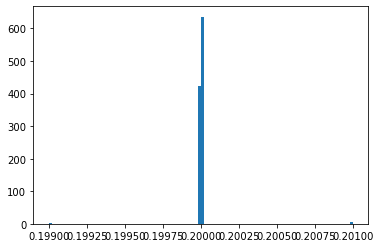

In [53]:
plt.hist(np.diff(a),100)

In [24]:
nshow = len(status)
htmltable = generate_table(status.iloc[:nshow,:-2], max_rows=nshow)
ixOrder = OrderedDict([(f"table-{col}-{i}",{"col":col,"index":i}) \
                       for i in range(nshow) for col in ["movie","(re)do pickles"]])

app = JupyterDash(__name__, width=1000)

app.layout = html.Div([
    html.Div("Please check which of the following series you wish processed into movies/pickles. When done, please click on the button and follow instructions."),
    html.Br(),
    html.Button(id="save",children=["Prepare script"],n_clicks=0),
    html.Div(id="output"),
    html.Div(htmltable,style={"width":"1000px"}),
    html.Pre(id="marked",children="------------",
             style={
                "width": "700px",
                "height": "300px",
                'overflowX': 'scroll',
                'overflowY': 'scroll',
                "display": "block" if "srdjan" in os.getcwd() else "none",
            }),
],style={"font-family":"Arial"})


@app.callback(
    Output("marked","children"),
    [Input(k,"value") for k in ixOrder]
)
def see(*manyinputs):
    print (manyinputs)
    out = deepcopy(ixOrder)
    for k,v in zip(out, manyinputs):
        out[k]["value"] = v
    out = list(out.values())
    
    for el in out:
        el["value"] = bool(len(el["value"]))
        i = status.index[el["index"]]
        el["rec"] = status.loc[i,"path"]
        el["ser"] = status.loc[i,"series"]
    out = pd.DataFrame(out)
    output = ""
    checklist_parse = []
    for (rec,ser),ddf in out.groupby(["rec","ser"]):
        el = {"rec":rec,"ser":ser}
        el["movie"] = ddf.query("col=='movie'")["value"].iloc[0]
        el["pickles"] = ddf.query("col=='(re)do pickles'")["value"].iloc[0]
#         for col in ["movie","(re)do pickles"][:1]:
#             el[col] = ddf.query("col==%s"%col)["value"]
        checklist_parse += [el]
    checklist_parse = pd.DataFrame(checklist_parse)
#     output += "\n"
#     output += str(checklist_parse)
#     output += "\n"
#     #################################### only movie begin
#     for _,row in checklist_parse.iterrows():
#         if not row["movie"]:
#             continue
#         outFile = "/.".join(os.path.split(row.rec))+".out"
#         line = ""
# #         for _ in range(3):
# #             line += f'''echo "" >> {outFile}\n'''
# #         line += f'''echo "###### processing started at: $(date)" >> {outFile}\n'''
#         line += f'''/data/useful_notebooks/process_single.py --recording="{row.rec}" --series="{row.ser}" --verbose --only-movie '''
#         line += f" >> {outFile}"
#         output += line+"\n"
#     #################################### only movie end
    #################################### good begin
    
    for rec in checklist_parse.rec.unique():
        outFile = "/.".join(os.path.split(rec))+".out"
        output += f"rm {outFile}\n"
    for _,row in checklist_parse.iterrows():
        if not row[["movie","pickles"]].any():
            continue
        outFile = "/.".join(os.path.split(row.rec))+".out"
        line = ""
        line += f"rm {outFile}\n"
        for _ in range(2):
            line += f'''echo "" >> {outFile}\n'''
        line += f'''echo "###### processing of {row.ser} started at: $(date)" >> {outFile}\n'''
#         line += f'''time notebooks/process_single_1.py --recording="{row.rec}" --series="{row.ser}" --verbose'''
        line += f'''time /data/useful_notebooks/process_single.py --recording="{row.rec}" --series="{row.ser}" --verbose'''
        if not row.movie:
            line += " --leave-movie"
        if not row.pickles:
            line += " --leave-pickles"
        line += f" >> {outFile}"
        output += line+"\n"
    #################################### good end
    
    return output

@app.callback(
    Output("output","children"),
    [Input("save","n_clicks")],
    [State("marked","children")]
)
def prepare_script(n_clicks, text):
    if n_clicks>0:
        with open(os.path.expanduser("~/processing_script.sh"),"w") as f:
            f.write(text)
        return dcc.Markdown("""`processing_script.sh` prepared in your home folder.

Just open new terminal and run: `bash processing_script.sh` 

You can then close the window and wait until the processing is finished. 

_(For now, there is no reallyt good way how to follow progress, sorry. You can try the cell below...)_
""")

app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'open the following link in a different tab (do not close this tab!): <a href="{link2app}">{link2app}</a>')
# app

In [25]:
# Hacky way to check progress
for exp,df in status.groupby("exp"):
    printExp = True
    for i,row in df.iterrows():
        assert (status.loc[i].iloc[:2] == status_orig.loc[i,["exp","series"]]).all()
        images = [f".image_{'%i.%i'%fs if isinstance(fs,tuple) else fs}.png" for fs in status_orig.loc[i,"pickles"]]
        serDir = f"{row.path}_analysis/{row.series}"
        if os.path.isdir(serDir):
            imDone = sum([el in images for el in os.listdir(serDir)])
        else:
            imDone = 0
        outPutFile = row.path.replace(row.exp, "."+row.exp+".out")
        percDone = 100/len(images)*imDone
    #     if percDone>=100: continue
        print ("%20s %13s  %3i%%"%(row.exp if printExp else "", row.series, percDone))#, outPutFile, os.path.isfile(outPutFile))
    #     if os.path.isfile(outPutFile):
    #         output = open(outPutFile).read()
    #         last = output#-1]
    #         last = "\n".join(["\t"+l for l in last.splitlines()])
    #         last += "\n"
    #         print(last)

    #     break
        printExp = False
    print ("-"*50)

   Experiment65a.lif     Series021  100%
                         Series025  100%
                         Series026  100%
                      Series033-35  100%
--------------------------------------------------
   Experiment65b.lif   Series006-9  100%
--------------------------------------------------
   Experiment65c.lif     Series006  100%
                      Series011-12  100%
--------------------------------------------------
   Experiment65d.lif     Series011  100%
                      Series039-40  100%
--------------------------------------------------
   Experiment66a.lif     Series009  100%
                      Series013-16  100%
--------------------------------------------------
   Experiment67a.lif  Series009-12  100%
--------------------------------------------------
   Experiment67b.lif   Series006-9    0%
                      Series012-17    0%
--------------------------------------------------
   Experiment67c.lif     Series011   75%
                         Ser